# Imports

In [1]:
## LOAD LIBRARIES
import pandas as pd
import numpy as np

# Import all we need from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

#Import optuna
import optuna

# Import visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Machine_Learning/Supervised_Learning/Data/Clean_Data_Titanic.csv')
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  adult_male  \
0         0       3    male  22.0      1      0   7.2500        S        True   
1         1       1  female  38.0      1      0  71.2833        C       False   
2         1       3  female  26.0      0      0   7.9250        S       False   
3         1       1  female  35.0      1      0  53.1000        S       False   
4         0       3    male  35.0      0      0   8.0500        S        True   

   alone  
0  False  
1  False  
2   True  
3  False  
4   True  


# Label Encoding

In [3]:
## CONVERT CATEGORICAL LABELS TO NUMERIC LABELS

le = LabelEncoder()
df['survived'] = le.fit_transform(df['survived'])

# OneHot Encoding of Categorical Variables

In [4]:
label_col = 'survived'

labels = df[label_col]
df.drop([label_col], inplace=True, axis=1)
df = pd.get_dummies(df, dtype='int', columns = ['pclass', 'sex', 'embarked', 'alone', 'adult_male'])
df[label_col] = labels

# Create Train and Test Sets

### For No Cross Validation

In [5]:
# X will contain all variables except the labels (the labels are the first column 'survived')
X = df.iloc[:,:-1]
# y will contain the labels (the labels are the first column 'survived')
y = df['survived']
               
# split the data vectors randomly into 80% train and 20% test
# X_train contains the quantitative variables for the training set
# X_test contains the quantitative variables for the testing set
# y_train contains the labels for training set
# y_test contains the lables for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Fit Initial Model

In [7]:
# documentation for parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DT_Classifier = DecisionTreeClassifier()
DT_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = DT_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[89 21]
 [19 50]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       110
           1       0.70      0.72      0.71        69

    accuracy                           0.78       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



# Tune Model - W/O Cross Validation

In [11]:
def objective(trial, X_train, y_train, X_test, y_test):

    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
        "splitter": trial.suggest_categorical("splitter", ['best', 'random']),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 10)
    }

    # Fit the model
    optuna_model = DecisionTreeClassifier(**param)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    score_metric = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    return score_metric

In [12]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 18:01:54,013] A new study created in memory with name: no-name-cfbfe515-d108-4583-94ba-7892a559303b


In [13]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

[I 2024-03-23 18:01:56,288] Trial 0 finished with value: 0.7946693657219973 and parameters: {'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7946693657219973.
[I 2024-03-23 18:01:56,314] Trial 1 finished with value: 0.768334771354616 and parameters: {'max_depth': 7, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7946693657219973.
[I 2024-03-23 18:01:56,337] Trial 2 finished with value: 0.7795566502463054 and parameters: {'max_depth': 9, 'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7946693657219973.


[I 2024-03-23 18:01:56,454] Trial 3 finished with value: 0.7853144989339019 and parameters: {'max_depth': 13, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7946693657219973.
[I 2024-03-23 18:01:56,476] Trial 4 finished with value: 0.7532395919492694 and parameters: {'max_depth': 7, 'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7946693657219973.
[I 2024-03-23 18:01:56,548] Trial 5 finished with value: 0.7425045427013931 and parameters: {'max_depth': 2, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7946693657219973.
[I 2024-03-23 18:01:56,567] Trial 6 finished with value: 0.7565644941939533 and parameters: {'max_depth': 5, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7946693657219973.
[I 

Best Trial:  FrozenTrial(number=16, state=1, values=[0.8054347826086956], datetime_start=datetime.datetime(2024, 3, 23, 18, 1, 57, 179079), datetime_complete=datetime.datetime(2024, 3, 23, 18, 1, 57, 261695), params={'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'splitter': CategoricalDistribution(choices=('best', 'random')), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=4, step=1)}, trial_id=16, value=None)
Best Params:  {'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 6}


### Cross Validate Tuned Model

In [14]:
cv_model = DecisionTreeClassifier(**best_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.74964189 0.78846154 0.82070707 0.86453254 0.8125561 ]
Average CV Score:  0.807179828604367
Number of CV Scores used in Average:  5


# Tune Model With Cross Validation

In [15]:
def objective(trial, X_train, y_train):

    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
        "splitter": trial.suggest_categorical("splitter", ['best', 'random']),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 10)
    }

    # Fit the model with cv
    cv_model = DecisionTreeClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(cv_model, X_train, y_train, cv = skf, scoring=make_scorer(f1_score, average='macro'))

    # Evaluate predictions
    return scores.mean()

In [16]:
# Generate a new study resetting trials to 0
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize"
)

[I 2024-03-23 18:02:41,527] A new study created in memory with name: no-name-c094a91d-7b37-4a85-b2de-cfc5bc29cffe


In [17]:
# study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, score_function), n_trials=100)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

print('Best Trial: ', study.best_trial)
print('Best Params: ',study.best_params)
best_params = study.best_params

[I 2024-03-23 18:02:43,327] Trial 0 finished with value: 0.7986839094897155 and parameters: {'max_depth': 4, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7986839094897155.


[I 2024-03-23 18:02:43,413] Trial 1 finished with value: 0.8075493484020526 and parameters: {'max_depth': 7, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8075493484020526.
[I 2024-03-23 18:02:43,525] Trial 2 finished with value: 0.8233259884996247 and parameters: {'max_depth': 3, 'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8233259884996247.
[I 2024-03-23 18:02:43,645] Trial 3 finished with value: 0.7983801652631114 and parameters: {'max_depth': 9, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8233259884996247.
[I 2024-03-23 18:02:43,736] Trial 4 finished with value: 0.8072227290923714 and parameters: {'max_depth': 8, 'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8233259884996247.
[I 202

Best Trial:  FrozenTrial(number=2, state=1, values=[0.8233259884996247], datetime_start=datetime.datetime(2024, 3, 23, 18, 2, 43, 416571), datetime_complete=datetime.datetime(2024, 3, 23, 18, 2, 43, 525922), params={'max_depth': 3, 'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'splitter': CategoricalDistribution(choices=('best', 'random')), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=4, step=1)}, trial_id=2, value=None)
Best Params:  {'max_depth': 3, 'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4}


### Validate CV Model with Test Set

In [18]:
DT_Classifier = DecisionTreeClassifier(**best_params)
DT_Classifier.fit(X_train, y_train)

## EVALUATE MODEL
y_pred = DT_Classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[95 15]
 [23 46]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



# Confusion Matrix

[[95 15]
 [23 46]]


[Text(0, 0.5, '0:'), Text(0, 1.5, '1:')]

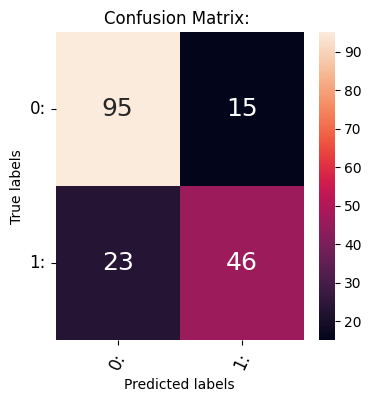

In [19]:
cm=confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)

# ---------------------------------------------------------------------------------------------------------------------------- #
## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: ')
ax.xaxis.set_ticklabels(["0:","1:"],rotation=65, fontsize = 12)

ax.yaxis.set_ticklabels(["0:","1:"],rotation=0, fontsize = 12)

# Feature Importance

C:\Users\casey\AppData\Local\Temp\ipykernel_18384\2029306045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=idx,x=values,palette=clrs).set(title='Important Features to Predict NFL Game Total Line Results')


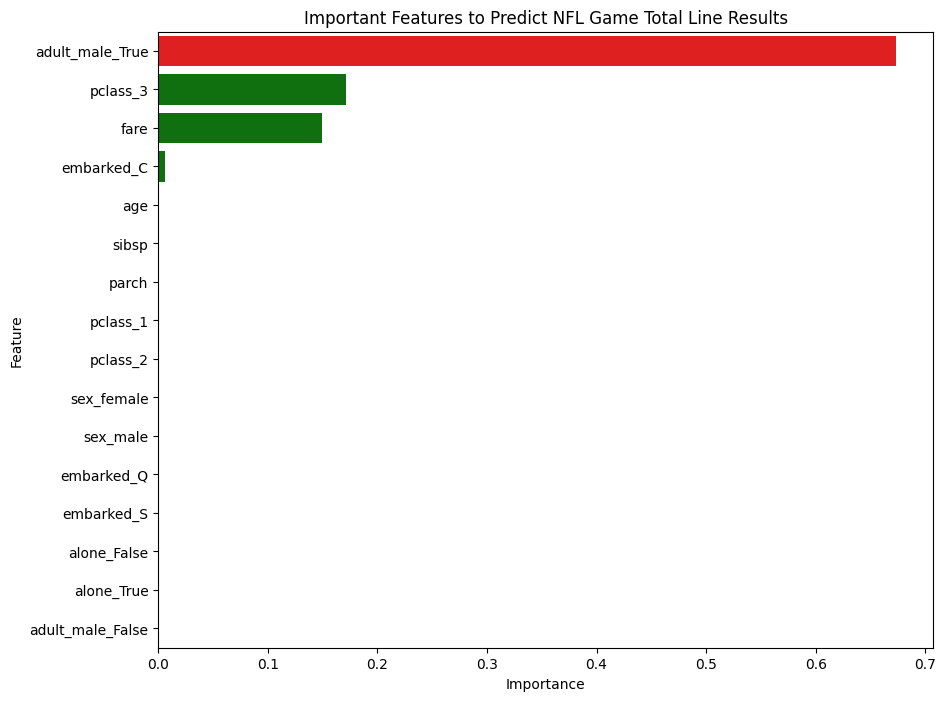

In [21]:
feat_dict= {}
for col, val in sorted(zip(X_train.columns, DT_Classifier.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
  
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

## PLOT FEATURE IMPORTANCE
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important Features to Predict NFL Game Total Line Results')
plt.show()

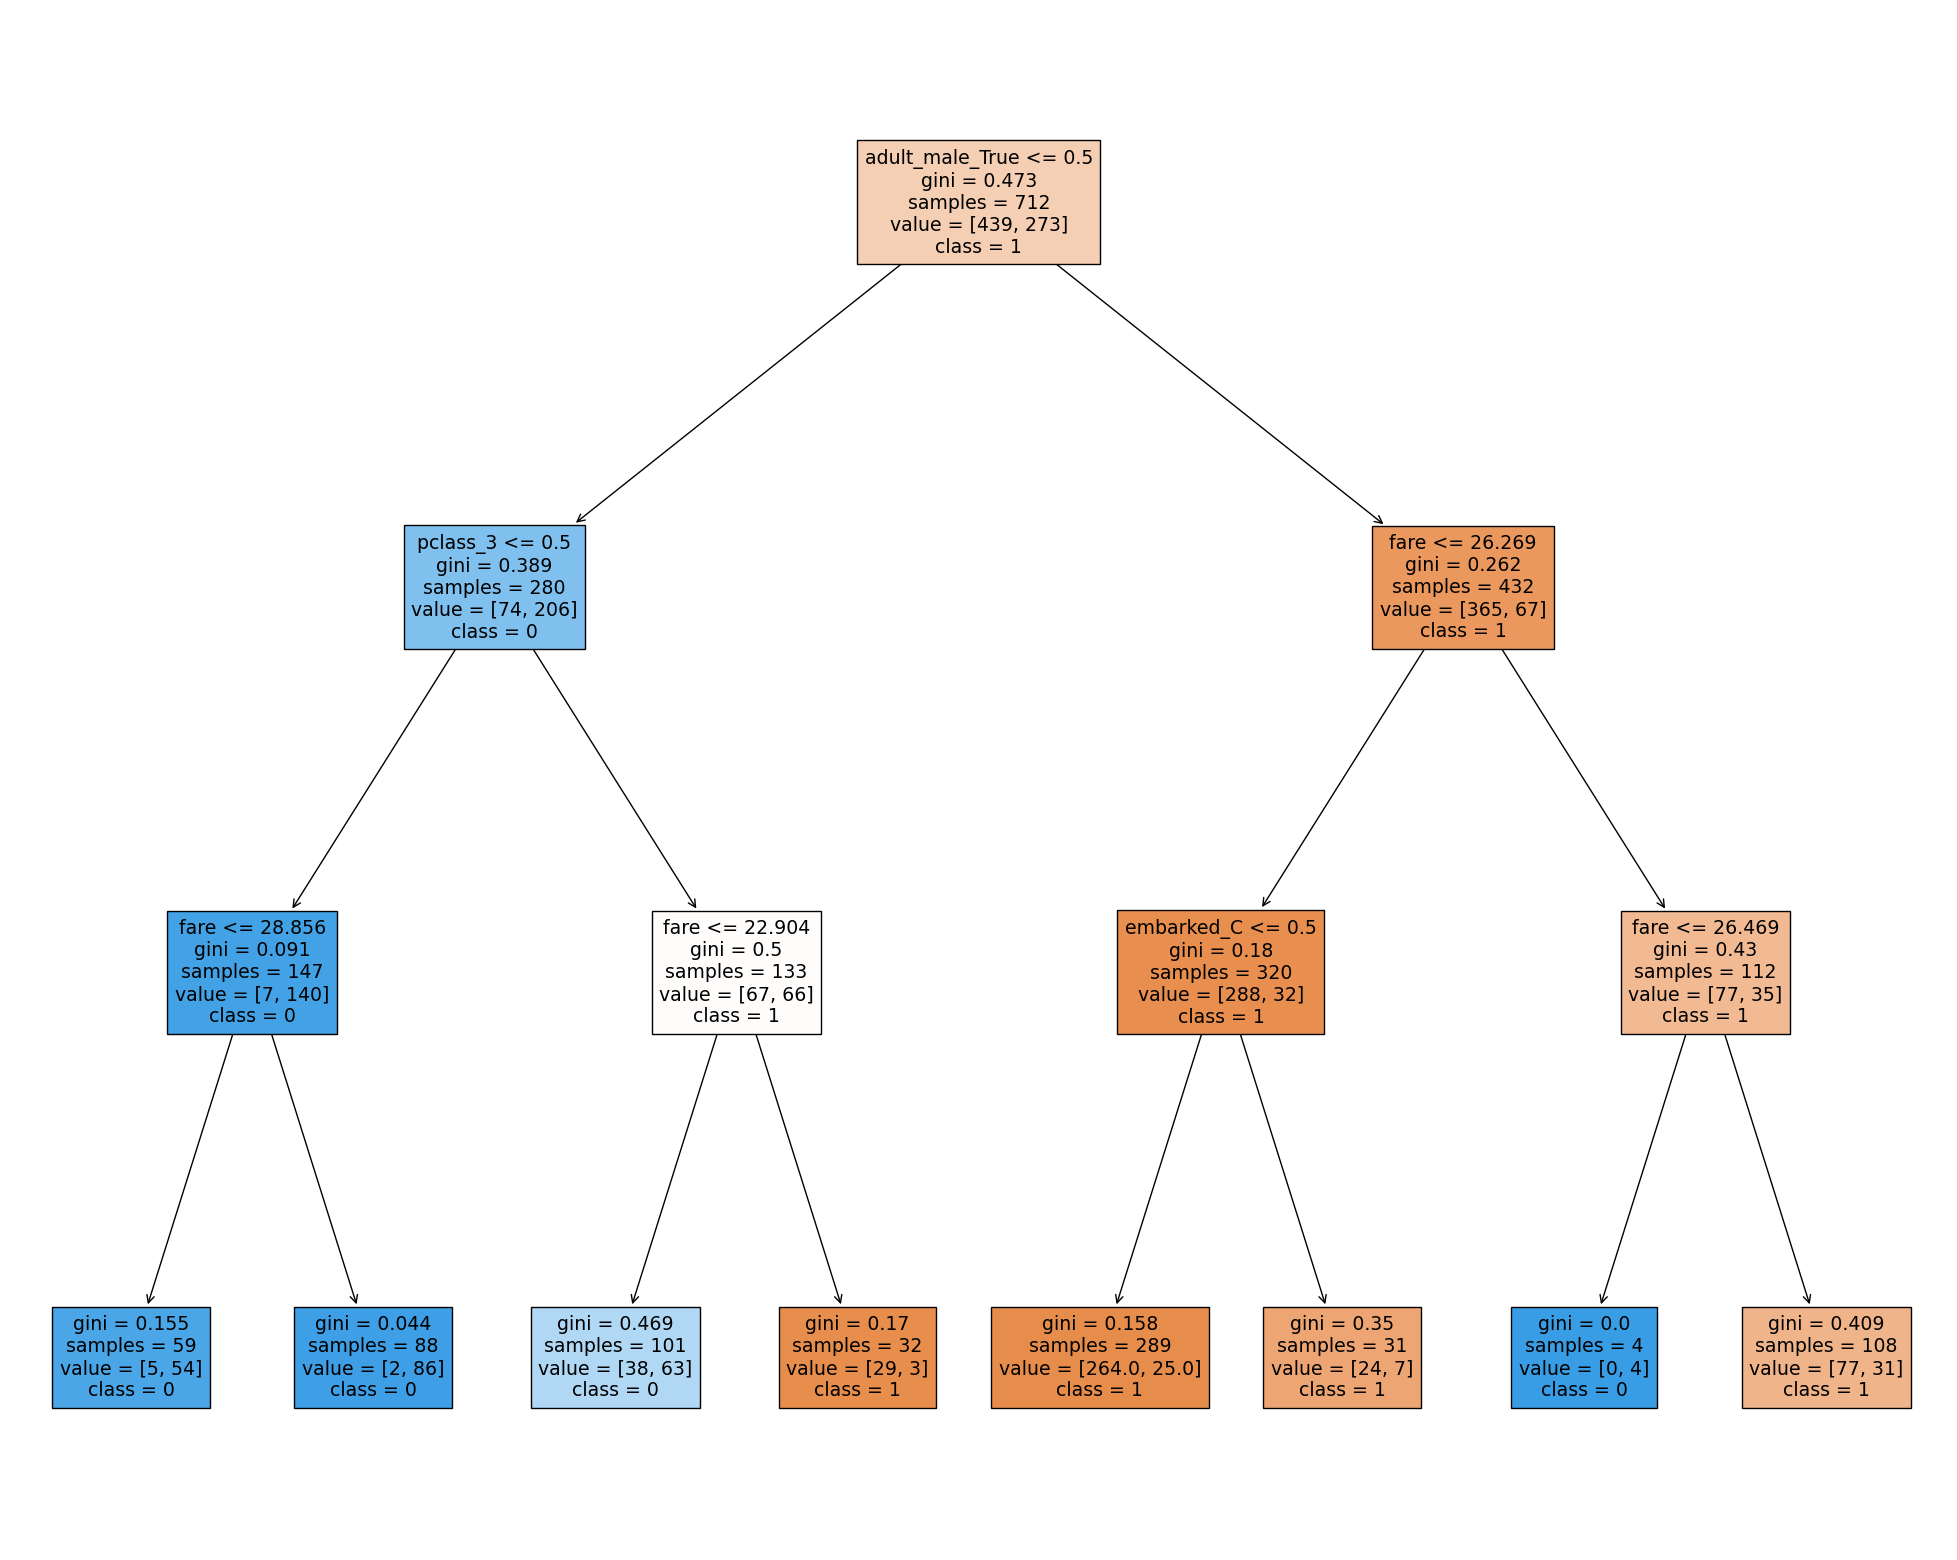

In [23]:
## VISUALIZE TREE
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT_Classifier, 
                   feature_names=X.columns,  
                   class_names=['1','0'],
                   filled=True)